In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:43 - loss: 0.0857 - STD: 2.2937e-04 - MAE: 0.2823

 13/632 [..............................] - ETA: 2s - loss: 0.0273 - STD: 3.1035e-04 - MAE: 0.1170   

 25/632 [>.............................] - ETA: 2s - loss: 0.0212 - STD: 3.4607e-04 - MAE: 0.1035

 37/632 [>.............................] - ETA: 2s - loss: 0.0187 - STD: 4.1505e-04 - MAE: 0.0921

 48/632 [=>............................] - ETA: 2s - loss: 0.0173 - STD: 5.3661e-04 - MAE: 0.0871

 59/632 [=>............................] - ETA: 2s - loss: 0.0163 - STD: 7.6355e-04 - MAE: 0.0840

 69/632 [==>...........................] - ETA: 2s - loss: 0.0157 - STD: 0.0011 - MAE: 0.0813    

 80/632 [==>...........................] - ETA: 2s - loss: 0.0151 - STD: 0.0020 - MAE: 0.0795

 92/632 [===>..........................] - ETA: 2s - loss: 0.0144 - STD: 0.0046 - MAE: 0.0768

103/632 [===>..........................] - ETA: 2s - loss: 0.0135 - STD: 0.0100 - MAE: 0.0737

113/632 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 0.0163 - MAE: 0.0707

125/632 [====>.........................] - ETA: 2s - loss: 0.0118 - STD: 0.0238 - MAE: 0.0675

135/632 [=====>........................] - ETA: 2s - loss: 0.0112 - STD: 0.0292 - MAE: 0.0652

146/632 [=====>........................] - ETA: 2s - loss: 0.0106 - STD: 0.0342 - MAE: 0.0630

158/632 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 0.0390 - MAE: 0.0608

170/632 [=======>......................] - ETA: 2s - loss: 0.0095 - STD: 0.0432 - MAE: 0.0589

182/632 [=======>......................] - ETA: 2s - loss: 0.0090 - STD: 0.0469 - MAE: 0.0572

194/632 [========>.....................] - ETA: 2s - loss: 0.0086 - STD: 0.0502 - MAE: 0.0556

206/632 [========>.....................] - ETA: 1s - loss: 0.0082 - STD: 0.0532 - MAE: 0.0542

219/632 [=========>....................] - ETA: 1s - loss: 0.0079 - STD: 0.0559 - MAE: 0.0528

231/632 [=========>....................] - ETA: 1s - loss: 0.0076 - STD: 0.0581 - MAE: 0.0517

243/632 [==========>...................] - ETA: 1s - loss: 0.0073 - STD: 0.0602 - MAE: 0.0506

254/632 [===========>..................] - ETA: 1s - loss: 0.0070 - STD: 0.0619 - MAE: 0.0497

266/632 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0639 - MAE: 0.0488

278/632 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0656 - MAE: 0.0480

290/632 [============>.................] - ETA: 1s - loss: 0.0064 - STD: 0.0673 - MAE: 0.0472

302/632 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0465

314/632 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0702 - MAE: 0.0459

326/632 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0713 - MAE: 0.0453

338/632 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0724 - MAE: 0.0447

349/632 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0733 - MAE: 0.0442

361/632 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0743 - MAE: 0.0437

373/632 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0752 - MAE: 0.0432

384/632 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0761 - MAE: 0.0428

395/632 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0769 - MAE: 0.0424

405/632 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0776 - MAE: 0.0421

416/632 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0783 - MAE: 0.0417

427/632 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0789 - MAE: 0.0414

439/632 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0410

450/632 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0407

461/632 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0404

466/632 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0403

477/632 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0400

487/632 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0398

497/632 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0395

508/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0393

518/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0391

528/632 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0839 - MAE: 0.0388

538/632 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0843 - MAE: 0.0386

549/632 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0384

560/632 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0851 - MAE: 0.0382

570/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0854 - MAE: 0.0380

580/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0857 - MAE: 0.0378

591/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0861 - MAE: 0.0376

602/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0864 - MAE: 0.0374

612/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0868 - MAE: 0.0373

624/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0871 - MAE: 0.0371

632/632 [==============================] - 5s 7ms/step - loss: 0.0039 - STD: 0.0874 - MAE: 0.0370 - val_loss: 0.0016 - val_STD: 0.0759 - val_MAE: 0.0288


Epoch 2/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0273

 11/632 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273 

 21/632 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0274

 31/632 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

 41/632 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

 51/632 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

 62/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

 72/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

 83/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

 93/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

104/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

114/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

124/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

134/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

144/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

154/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

164/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

174/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

184/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

196/632 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

208/632 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0272

220/632 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

232/632 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

244/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

256/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

268/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

280/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

292/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

304/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

316/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

328/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

340/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

352/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

364/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

376/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

388/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

400/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

412/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

424/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

436/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

448/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

460/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0272

472/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0272

484/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0272

496/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0272

508/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0272

520/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

532/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

544/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

556/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

568/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

580/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

592/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

604/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

616/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

629/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270 - val_loss: 0.0015 - val_STD: 0.0789 - val_MAE: 0.0279


Epoch 3/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0262

 12/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267 

 24/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0274

 36/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0275

 48/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0275

 60/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0273

 72/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0272

 84/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

 96/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

108/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

120/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

132/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

142/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

153/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

165/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

177/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

189/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

201/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

212/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

224/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

236/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

248/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

260/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

272/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

284/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

296/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

309/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

322/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

334/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

346/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

359/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

371/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

383/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

394/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

405/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

417/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

429/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

440/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

452/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

465/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

478/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

490/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

502/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

514/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

526/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

538/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

549/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

560/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

570/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

580/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

591/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

602/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

613/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

624/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264 - val_loss: 0.0021 - val_STD: 0.0855 - val_MAE: 0.0312


Epoch 4/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0012 - STD: 0.1091 - MAE: 0.0253

 12/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266 

 24/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

 37/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

 50/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0264

 62/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

 74/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

 86/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

 96/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

106/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

117/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

127/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

138/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

149/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

160/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

171/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

182/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

193/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

204/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

215/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

225/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

236/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

247/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

259/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

271/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

282/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

294/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

307/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

319/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

331/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

343/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

355/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

366/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

376/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

386/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

396/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

406/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

416/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

426/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

436/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

446/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

456/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

466/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

476/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

486/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

496/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

506/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

516/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

527/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

539/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

551/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

563/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

575/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

587/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

599/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

611/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

623/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0831 - val_MAE: 0.0282


Epoch 5/10000


  1/632 [..............................] - ETA: 9s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0249

 12/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1082 - MAE: 0.0250

 23/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

 33/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0252

 45/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

 57/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

 69/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

 81/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

 92/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0254

103/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0254

114/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

124/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

134/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

144/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

155/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

167/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

178/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

189/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

200/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

212/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

223/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

233/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

244/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

256/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

268/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

278/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

288/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

298/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

308/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

318/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

328/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

338/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

348/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

359/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

369/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

379/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

389/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

399/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

410/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

420/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

431/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

442/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

452/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

462/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

472/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

482/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

493/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

503/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

513/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

524/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

534/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

545/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

555/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

565/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

575/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

585/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

595/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

605/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

615/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

627/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257 - val_loss: 0.0015 - val_STD: 0.0820 - val_MAE: 0.0267


Epoch 6/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0259

 11/632 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255 

 22/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

 32/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0253

 42/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

 52/632 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

 62/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

 72/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

 82/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

 94/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

105/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

114/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0255

124/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

134/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

144/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

154/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

165/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

177/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

187/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

197/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

208/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

219/632 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

230/632 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

241/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

251/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

261/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

271/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

281/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

293/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

305/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

317/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

329/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

341/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

353/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

365/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

377/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

389/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

401/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

413/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

425/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

437/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

449/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

461/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

473/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

486/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

498/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

511/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

524/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

536/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

548/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

560/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

572/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

584/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

596/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

608/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

621/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250 - val_loss: 0.0016 - val_STD: 0.0861 - val_MAE: 0.0277


Epoch 7/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1028 - MAE: 0.0233

 12/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246 

 22/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0246

 32/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

 42/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

 52/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

 62/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0250

 72/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

 82/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

 92/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

102/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

114/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

126/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

138/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

150/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

162/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

173/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

182/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

192/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

202/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

212/632 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

222/632 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

234/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

246/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

258/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

270/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

282/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

294/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

306/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0248

318/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

329/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

340/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

350/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

360/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

370/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

381/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

392/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

403/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

413/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

423/632 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

433/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

443/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

454/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

464/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

474/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

484/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

494/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

504/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

514/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

524/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

534/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

544/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

554/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

565/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

576/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

588/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

600/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

612/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

624/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247 - val_loss: 0.0016 - val_STD: 0.0867 - val_MAE: 0.0276


Epoch 8/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1114 - MAE: 0.0245

 12/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1082 - MAE: 0.0239 

 24/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1080 - MAE: 0.0240

 36/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0239

 48/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

 61/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

 73/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0239

 86/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0239

 98/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0239

110/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0239

119/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0239

129/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0239

140/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

151/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

163/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

175/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

187/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

199/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0241

211/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

223/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

235/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

247/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

259/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

271/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

283/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

295/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

307/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

320/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

332/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

344/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

356/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

368/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

380/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

392/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

404/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

416/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

428/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

440/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

452/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

464/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

476/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

488/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

500/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

512/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

524/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

536/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

548/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

560/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

572/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

584/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

597/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

609/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

621/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242 - val_loss: 0.0018 - val_STD: 0.0858 - val_MAE: 0.0285


Epoch 9/10000


  1/632 [..............................] - ETA: 11s - loss: 9.5676e-04 - STD: 0.1081 - MAE: 0.0221

 11/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1085 - MAE: 0.0233     

 21/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

 31/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1084 - MAE: 0.0234

 41/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1085 - MAE: 0.0235

 51/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0235

 61/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

 71/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

 81/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

 91/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

101/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0236

111/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0235

121/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0235

131/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0235

141/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0235

151/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

160/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0237

169/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

179/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

189/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

199/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

210/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

220/632 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

230/632 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0238

240/632 [==========>...................] - ETA: 2s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0237

250/632 [==========>...................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

260/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

270/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

281/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

291/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

301/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

311/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

321/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

333/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

344/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

354/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

364/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

374/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

384/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

395/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0237

406/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

416/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

427/632 [===================>..........] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

437/632 [===================>..........] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

447/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

458/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

469/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

479/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

489/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

499/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

509/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

519/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

529/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

539/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

550/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

562/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

574/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

586/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

598/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

610/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

622/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236 - val_loss: 0.0022 - val_STD: 0.0888 - val_MAE: 0.0315


Epoch 10/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0011 - STD: 0.1113 - MAE: 0.0232

 13/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1080 - MAE: 0.0239 

 25/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1095 - MAE: 0.0244

 37/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1094 - MAE: 0.0244

 49/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1090 - MAE: 0.0243

 61/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1084 - MAE: 0.0245

 73/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1083 - MAE: 0.0244

 84/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1082 - MAE: 0.0243

 94/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1082 - MAE: 0.0242

104/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1081 - MAE: 0.0242

115/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1080 - MAE: 0.0240

127/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0240

139/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0239

150/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

162/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

174/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

186/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

198/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

210/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

222/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0237

234/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0237

246/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0236

258/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0236

270/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

282/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0235

294/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

306/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0236

318/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0237

330/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0237

342/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

354/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

367/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

380/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

393/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

405/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

418/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

430/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

442/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

454/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

466/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

478/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

490/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

502/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

514/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

526/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

538/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

550/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

562/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

574/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

587/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

600/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

613/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

626/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235 - val_loss: 0.0024 - val_STD: 0.0898 - val_MAE: 0.0324


Epoch 11/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0013 - STD: 0.1105 - MAE: 0.0249

 12/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1062 - MAE: 0.0230 

 24/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

 36/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0236

 48/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0237

 60/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0236

 72/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0235

 84/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0233

 96/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

107/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

119/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0232

131/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0232

143/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

155/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

167/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0232

178/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

188/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

198/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

208/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

218/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

229/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

240/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

252/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

264/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

276/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

288/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

300/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

312/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

324/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

336/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0230

348/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0230

361/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

374/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

386/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

398/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

410/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

422/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

433/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

443/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

454/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

465/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

475/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

484/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

494/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

506/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

518/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

530/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

543/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

556/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

568/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

580/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

591/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

601/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

613/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

625/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230 - val_loss: 0.0018 - val_STD: 0.0875 - val_MAE: 0.0282


Epoch 12/10000


  1/632 [..............................] - ETA: 9s - loss: 9.9640e-04 - STD: 0.1105 - MAE: 0.0220

 13/632 [..............................] - ETA: 2s - loss: 0.0010 - STD: 0.1086 - MAE: 0.0224    

 25/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1086 - MAE: 0.0225

 37/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0225

 49/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

 61/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

 73/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

 85/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

 97/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

110/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

123/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

136/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

149/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

162/632 [======>.......................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

175/632 [=======>......................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

188/632 [=======>......................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

200/632 [========>.....................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

213/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

225/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

237/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

249/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

262/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

275/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

288/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

301/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0229

314/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0229

327/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

339/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

351/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

363/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0229

376/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

388/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

399/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

409/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

421/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

432/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

443/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

455/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

466/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

479/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

492/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

505/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

517/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

529/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

542/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

555/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

567/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

579/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

591/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

604/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

616/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

628/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228 - val_loss: 0.0022 - val_STD: 0.0875 - val_MAE: 0.0311


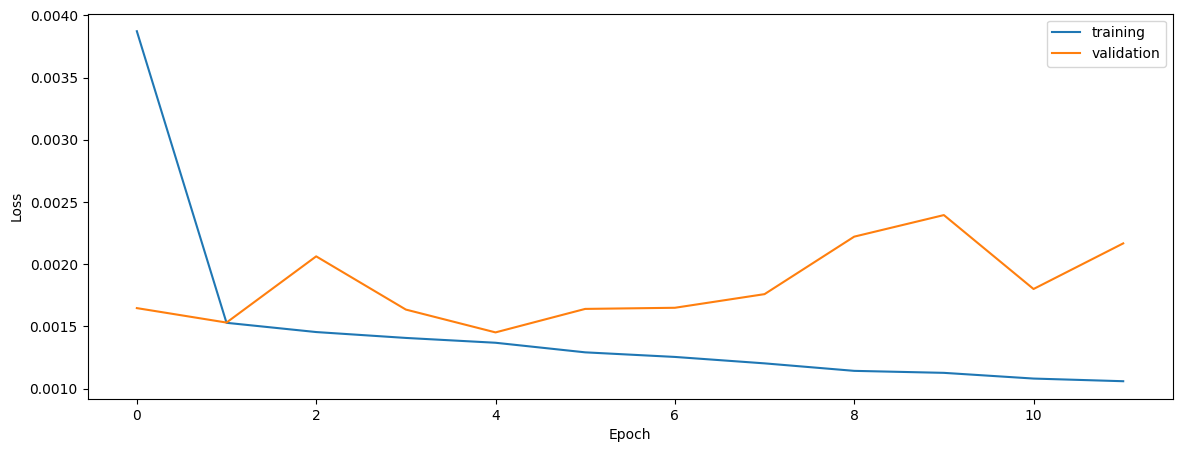

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.948568540911692
0.958544127563844
0.9482497054376758


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9484164878891992
0.9548331102435853
0.951763666514422


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.954696381940991
0.9563756958525772
0.9630018304981363


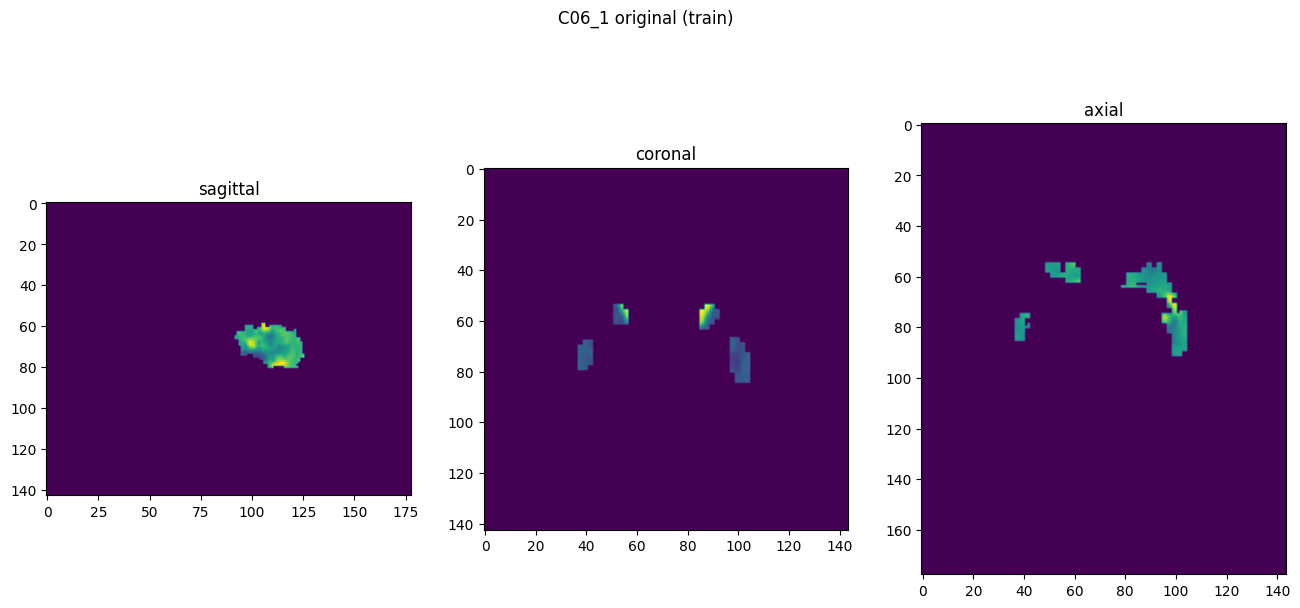

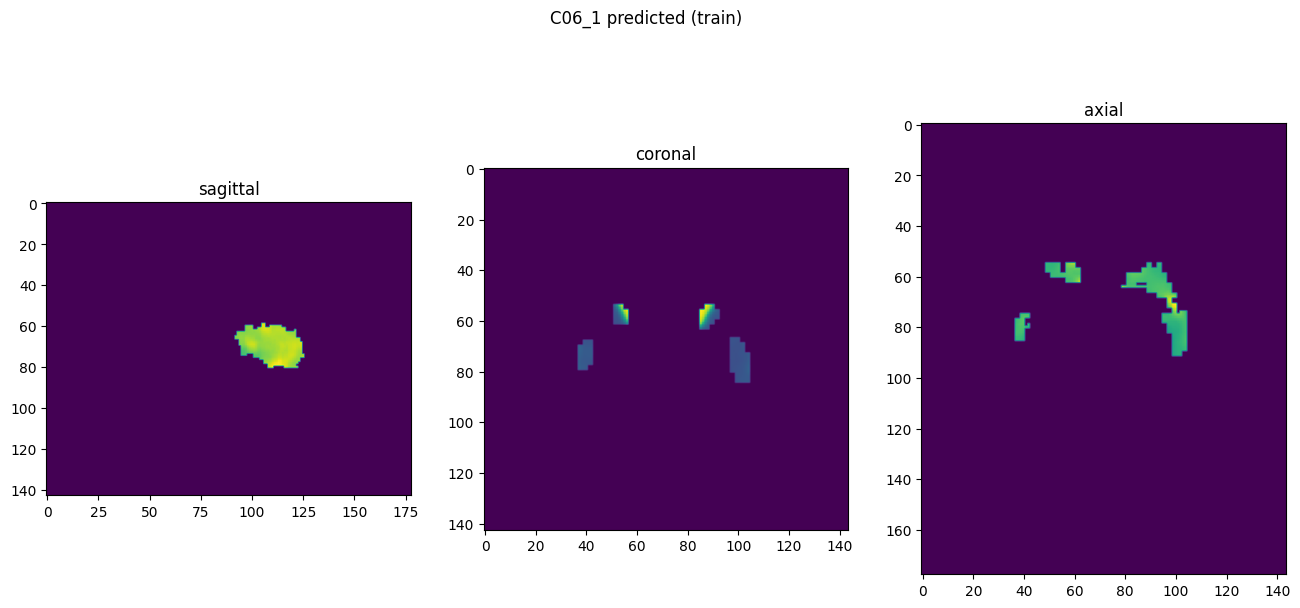

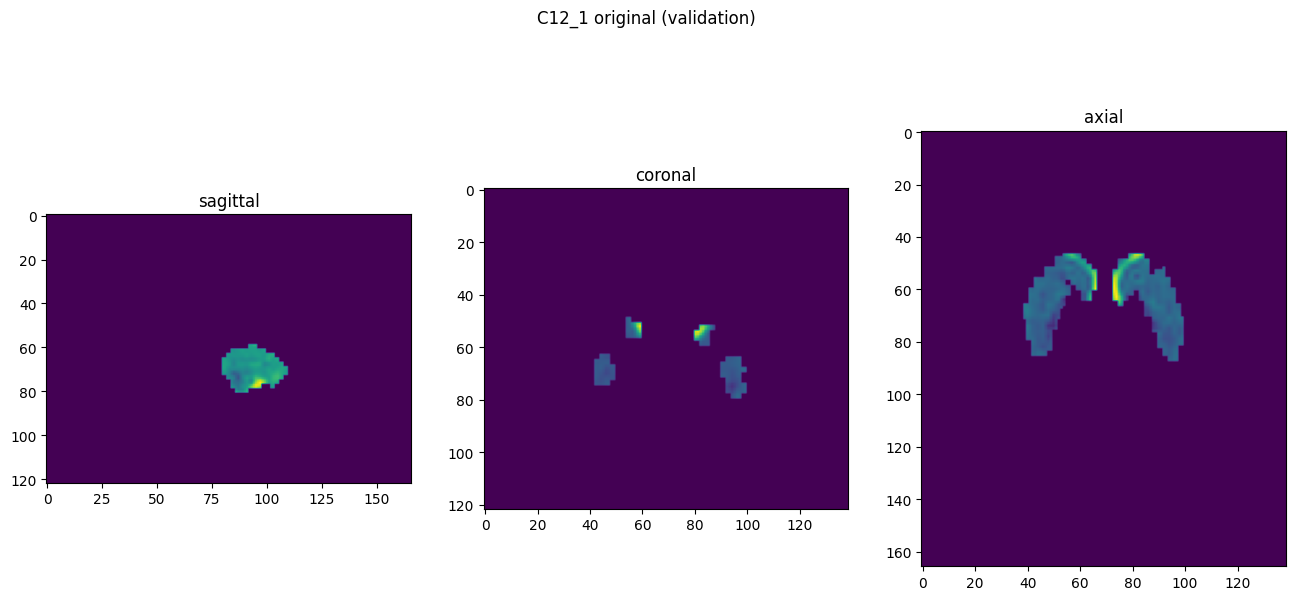

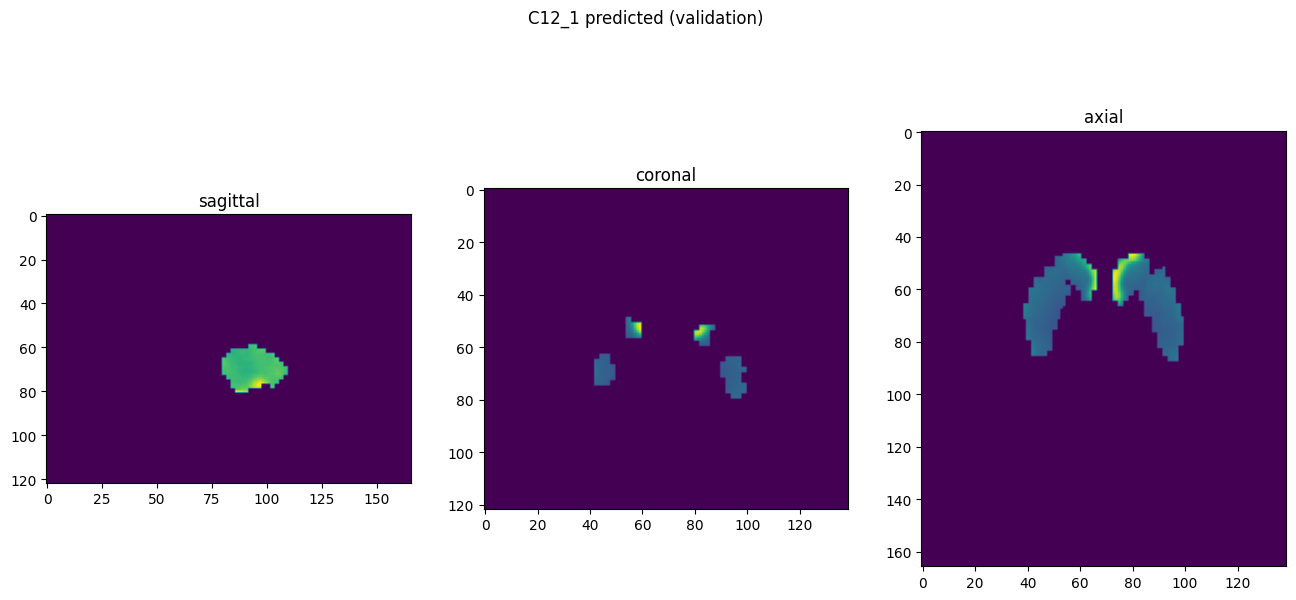

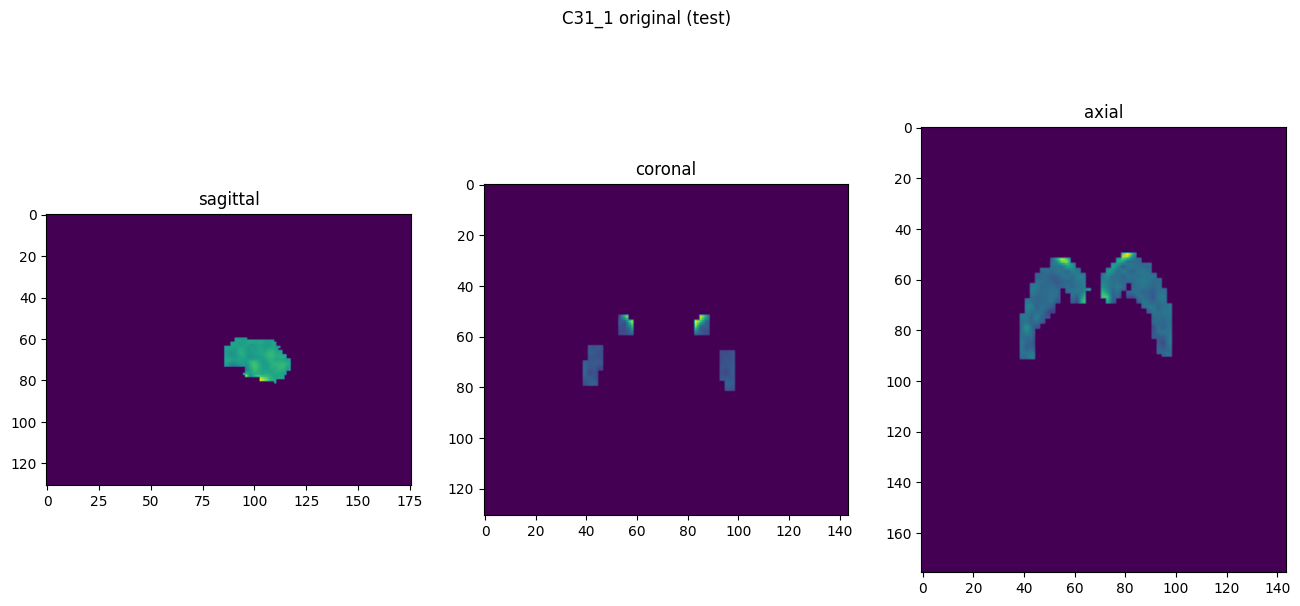

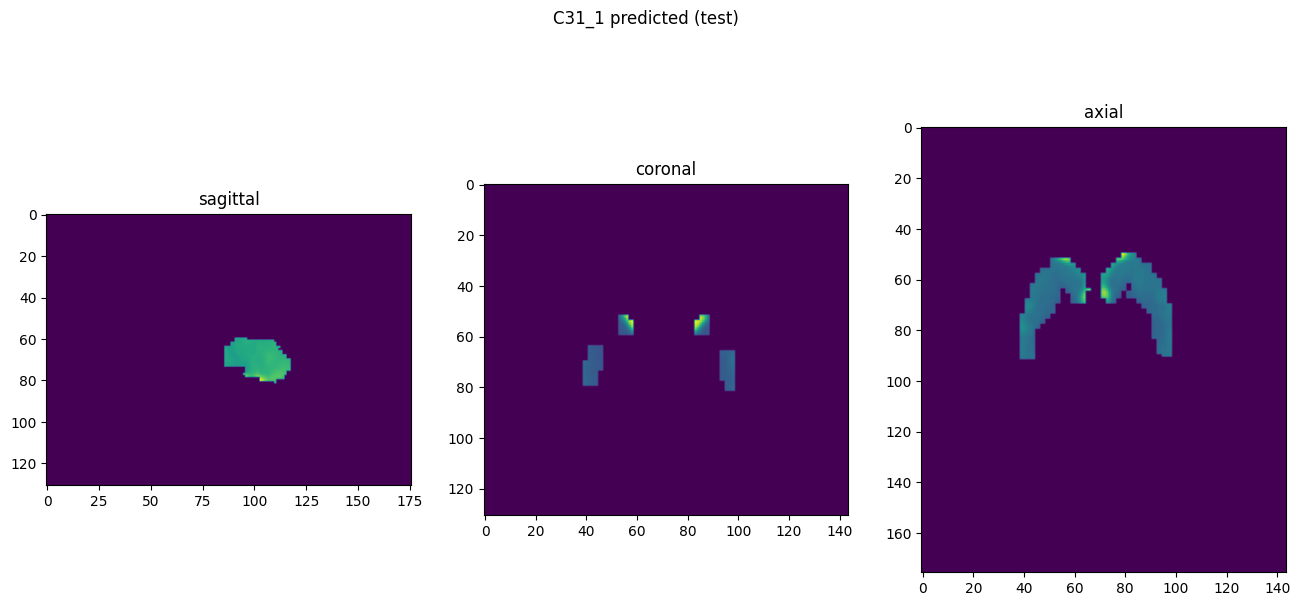

In [10]:
showResults(model, gen, threshold=None, background=False)